In [1]:
import pathlib

import e3psi.models
import hubbardml
from hubbardml import keys, plots
import numpy as np
import torch

hubbardml.utils.random_seed()

dtype = torch.float64
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [2]:
VALIDATE_PERCENTAGE = 0.2
# DATASET = 'data_uv_2022_7_25.json'
# DATASET = 'data_uv_2022_8_18.json'
DATASET = "../data/data_uv_unique_inout_2022_10_13.json"
# DATASET = 'data_uv_unique_in_2022_8_18.json'
# DATASET = 'data_uv_2022_8_18.json'  # Psi-k dataset
SAVEFIGS = False
TARGET_PARAM = 'U'
DELTA_LEARNING = False

def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
df = hubbardml.models.UModel.prepare_dataset(df)
len(df)

365

## Model creation

In [20]:
species = list(df[keys.ATOM_1_ELEMENT].unique())
model = hubbardml.models.UModel(
    species,
    hidden_layers=2,
    rescaler = hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean")
)
model.to(dtype=dtype, device=device)

UModel(
  (layers): ModuleList(
    (0): TensorSquare(6x0e+1x2e+1x4e+1x0e+1x2e+1x4e -> 36x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e | 1444 paths | 1444 weights)
    (1): Gate (36x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e -> 23x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e)
    (2): TensorSquare(23x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e -> 36x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e | 12716 paths | 12716 weights)
    (3): Gate (36x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e -> 23x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e)
    (4): TensorSquare(23x0e+4x2e+1x3e+4x4e+1x5e+2x6e+1x8e -> 1x0e | 302 paths | 302 weights)
    (5): Rescaler()
  )
)

## Split test/train

In [6]:
hubbardml.datasets.split(df, method='category', frac=0.2, category=['species'])

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_final_mag,atom_1_occs_inv_1,atom_1_occs_inv_2,atom_2_occs_inv_1,atom_2_occs_inv_2,param_delta,species,label,colour,training_label
0,/home/martin/docs/academic/projects/dftuv/data...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,0.0000,"[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...","[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...",10.2709,(Ni),Ni,#50D050,validate
78,/home/martin/docs/academic/projects/dftuv/data...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,0.7291,"[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,train
118,/home/martin/docs/academic/projects/dftuv/data...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,-0.7291,"[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,train
161,/home/martin/docs/academic/projects/dftuv/data...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,0.7290,"[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,train
197,/home/martin/docs/academic/projects/dftuv/data...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,-0.7291,"[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65276,/home/martin/docs/academic/projects/dftuv/data...,B5_Li1.00MnPO4,False,3,,"[19.794085076499996, 0.0, 0.0, 0.0, 11.5117365...",28,iurii,111,1.594749e+09,...,-4.2040,"[[1.016, 0.001, -0.0, 0.005, 0.0], [0.001, 1.0...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...","[[1.016, 0.001, -0.0, 0.005, 0.0], [0.001, 1.0...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...",0.1188,(Mn),Mn,#9C7AC7,train
65669,/home/martin/docs/academic/projects/dftuv/data...,B5_Li1.00MnPO4,False,4,,"[19.794085076499996, 0.0, 0.0, 0.0, 11.5117365...",28,iurii,112,1.595849e+09,...,4.2058,"[[1.016, 0.001, -0.0, 0.005, 0.0], [0.001, 1.0...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...","[[1.016, 0.001, -0.0, 0.005, 0.0], [0.001, 1.0...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...",-0.0129,(Mn),Mn,#9C7AC7,train
65754,/home/martin/docs/academic/projects/dftuv/data...,B5_Li1.00MnPO4,False,4,,"[19.794085076499996, 0.0, 0.0, 0.0, 11.5117365...",28,iurii,112,1.595849e+09,...,4.2058,"[[1.016, -0.001, -0.0, 0.005, 0.0], [-0.001, 1...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...","[[1.016, -0.001, -0.0, 0.005, 0.0], [-0.001, 1...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...",-0.0129,(Mn),Mn,#9C7AC7,validate
65854,/home/martin/docs/academic/projects/dftuv/data...,B5_Li1.00MnPO4,False,4,,"[19.794085076499996, 0.0, 0.0, 0.0, 11.5117365...",28,iurii,112,1.595849e+09,...,-4.2058,"[[1.016, -0.001, -0.0, 0.005, 0.0], [-0.001, 1...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...","[[1.016, -0.001, -0.0, 0.005, 0.0], [-0.001, 1...","[[0.01992, -2e-06, 0.0, -6e-06, 0.0], [-2e-06,...",-0.0129,(Mn),Mn,#9C7AC7,validate


In [21]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.loc[train_idx][keys.ATOM_1_ELEMENT].value_counts())
print(df.loc[validate_idx][keys.ATOM_1_ELEMENT].value_counts())

Ni    138
Mn     85
Fe     62
Co      4
Ti      3
Name: atom_1_element, dtype: int64
Ni    34
Mn    21
Fe    16
Co     1
Ti     1
Name: atom_1_element, dtype: int64


In [22]:
trainer = hubbardml.Trainer.from_frame(
    model = model,
    opt = torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn = torch.nn.MSELoss(),
    frame = df,
    target_column=keys.PARAM_DELTA if DELTA_LEARNING else keys.PARAM_OUT,
)

In [23]:
trainer.overfitting_window = 400
trainer.train(
    callback=print,
    callback_period=50,
    max_iters=100_000
)

iter=0 train_loss=7.924354910620535 validate_loss=6.0941965283226995
iter=50 train_loss=1.5277623565095586 validate_loss=1.6630457322041212
iter=100 train_loss=0.8174331547068164 validate_loss=0.8784183354638833
iter=150 train_loss=0.4196664707772125 validate_loss=0.42515973509382515
iter=200 train_loss=0.25576376748710944 validate_loss=0.2193806595238629
iter=250 train_loss=0.2352617843584594 validate_loss=0.1983939588442335
iter=300 train_loss=0.22284974785552888 validate_loss=0.19335602892090298
iter=350 train_loss=0.2125871926084534 validate_loss=0.18900788354129422
iter=400 train_loss=0.2037786215251192 validate_loss=0.18539481645266273
iter=450 train_loss=0.19603840038639292 validate_loss=0.18222605588012156
iter=500 train_loss=0.1890551071658628 validate_loss=0.17931909753756006
iter=550 train_loss=0.1825173075725744 validate_loss=0.1765068228775503
iter=600 train_loss=0.1760612289079039 validate_loss=0.17360813885308723
iter=650 train_loss=0.16933809086166954 validate_loss=0.17

KeyboardInterrupt: 

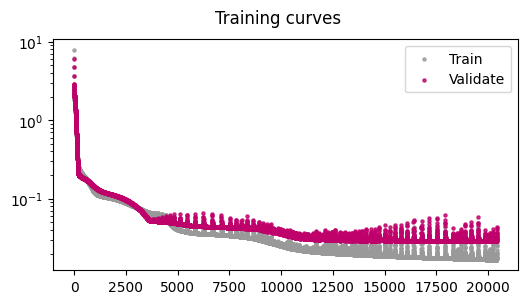

In [24]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')

In [25]:
predicted = model(trainer.input_validate).detach().cpu().numpy().reshape(-1)
predicted_train = model(trainer.input_train).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = predicted_train

if DELTA_LEARNING:
    df[keys.PARAM_OUT_PREDICTED] += df[keys.PARAM_IN]

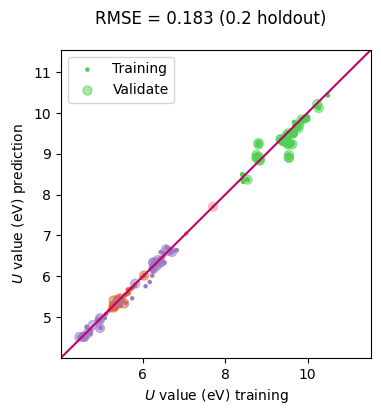

In [26]:
def rmse(y1, y2):
    return np.sqrt(((y1-y2)**2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)', axis_label=f'${TARGET_PARAM}$ value (eV)');

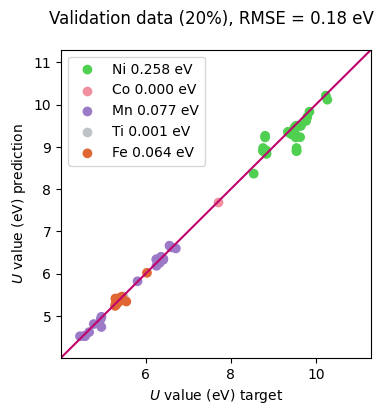

In [27]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

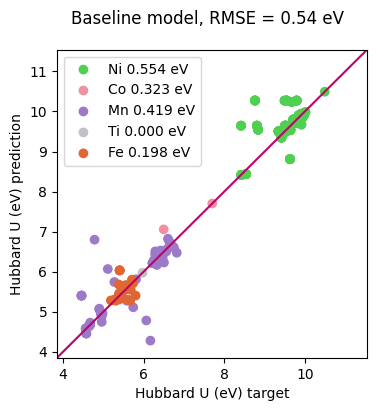

In [28]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

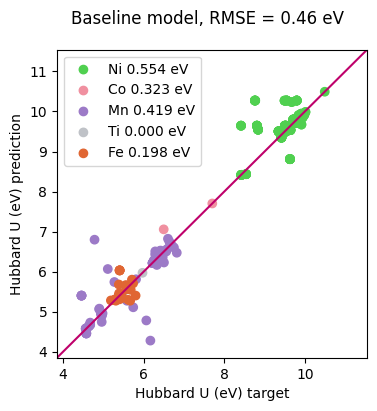

In [29]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [30]:
{str(pathlib.Path(directory).parent) for  directory in df[keys.DIR].unique()}

{'/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/1_LixCoO2/1_CoO2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/1_LixCoO2/1_LiCoO2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/2_LixNiO2/1_LiNiO2_DFT_plus_UV_v3',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/2_LixNiO2/1_NiO2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/3_LixMnO2/3_LiMnO2_DFT_plus_UV_v3',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/3_LixMnO2/3_MnO2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/4_LixTiS2/4_LiTiS2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Layered/4_LixTiS2/4_TiS2_DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Olivines/LiFe0.5Mn0.5PO4/A1_Li0.00Mn0.5Fe0.5PO4/DFT_plus_UV',
 '/home/martin/docs/academic/projects/dftuv/data/raw/iurii/Olivines/LiFePO4/C1_Li

In [31]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

6.0375


TypeError: create_progression_plots() got multiple values for argument 'yrange'

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy
fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
